# Cleaning data

In [ ]:
import pandas as pd
from tqdm import tqdm
import re

In [ ]:
# read the data
data = pd.read_csv('data/csv/data.csv')

In [ ]:
# seperate the data into two parts according to their VAP (0 or 1) and put them into two variables
data_0 = data[data['VAP'] == 0]
data_1 = data[data['VAP'] == 1]

# print the number of rows of the two variables
print("Class 0: ", data_0.shape[0])
print("Class 1: ", data_1.shape[0])

In [ ]:
# get the values in the TEXT column for each class
text_0 = data_0['TEXT'].values
text_1 = data_1['TEXT'].values

# make a set of all the words in the TEXT column for each class
words_0 = set()
for text in tqdm(text_0):
    for word in text.split():
        words_0.add(word)

words_1 = set()
for text in tqdm(text_1):
    for word in text.split():
        words_1.add(word)
    
# make a set of words that are in both classes
words_both = set()
for word in tqdm(words_0):
    if word in words_1:
        words_both.add(word)

In [ ]:
# print the number of unique words in each class
print("Class 0: ", len(words_0))
print("Class 1: ", len(words_1))
print("Both: ", len(words_both))

In [ ]:
threshold = 0.2
words_to_remove = set()

for word in tqdm(words_both):
    count_0 = 0
    count_1 = 0

    # count the number of times the word appears in each class
    for text in text_0:
        if word in text:
            count_0 += 1
    for text in text_1:
        if word in text:
            count_1 += 1
    
    # calculate the probability of the word appearing in each class
    prob_0 = count_0 / data_0.shape[0]
    prob_1 = count_1 / data_1.shape[0]

    # calculate the ratio of the probability of the word appearing in each class
    ratio = prob_1 / prob_0

    # if the ratio is close to 1 by a certain threshold, remove the word from the set of words that are in both classes
    if ratio >= 1 - threshold and ratio <= 1 + threshold:
        words_to_remove.add(word)

In [ ]:
# print the number of words to remove
print("Words to remove: ", len(words_to_remove))

In [ ]:
print(words_to_remove)

In [ ]:
# Compile a single regular expression that matches any word in words_to_remove
pattern = r'\b(?:' + '|'.join(re.escape(word) for word in words_to_remove) + r')\b'
regex = re.compile(pattern)

In [ ]:
def remove_words(text):
    # Replace matched words with a single space
    text = regex.sub(' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
# make a copy of the dataframe
print("Making a copy of the dataframe...")
data_cpy = data.copy()

# remove the words from the TEXT column for each row
print("Removing the words from the TEXT column for each row...")
for i in tqdm(range(data_cpy.shape[0])):
    # remove the words from the TEXT column
    text = remove_words(data_cpy.at[i, 'TEXT'])

    # if the new text is empty or contains less than 5 words, remove the row
    if len(text) == 0 or len(text.split()) < 5:
        data_cpy.drop(i, inplace=True)
        continue

    # update the TEXT column
    data_cpy.at[i, 'TEXT'] = text

# save the dataframe to a csv file
print("Saving the dataframe to a csv file...")
data_cpy.to_csv('data/csv/data_cleaned.csv', index=False)

# Embedding

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("data/csv/data_cleaned.csv")

In [ ]:
# creating a matrix of word embeddings using the cleaned data and the BioWordVec model
import gensim
import numpy as np

model = gensim.models.KeyedVectors.load_word2vec_format("bin/pubmed.bin", binary=True)

# function to create a matrix of word embeddings
def get_word_embeddings(sample):
    # initialize a matrix of zeros
    embeddings = np.zeros(200)
    # get the words in the sample
    words = sample.split()
    # get the number of words
    num_words = len(words)
    # loop over the words
    for word in words:
        # check if the word is in the model's vocabulary
        if word in model.key_to_index :
            # add the word embedding to the matrix
            embeddings += model[word]
    # return the matrix divided by the number of words
    return np.array(embeddings / num_words)

In [ ]:
# apply the function to the TEXT column, for each embedding, create a new column
df[["embedding_" + str(i) for i in range(200)]] = df["TEXT"].apply(get_word_embeddings).to_list()

# save the dataframe
df.to_csv("data/csv/data_embedded.csv", index=False)

## Processed data

In [ ]:
import pandas as pd
import numpy as np
import tqdm
import re

In [ ]:
df = pd.read_csv("data/csv/data_embedded.csv")

In [ ]:
# augment the class 1 data using SMOTE
from imblearn.over_sampling import SMOTE

# seperate the features and the labels, the features are the word embeddings, each embedding is a column
X = df[[col for col in df.columns if "embedding" in col]]
y = [int(i) for i in df["VAP"].tolist()]

# initialize the SMOTE object
sm = SMOTE(random_state=42)

# fit the SMOTE object to the data
X_res, y_res = sm.fit_resample(X, y)

# create a dataframe from the augmented data
df_res = pd.DataFrame(X_res, columns=X.columns)
df_res["VAP"] = y_res

# save the dataframe
df_res.to_csv("data/csv/data_resampled.csv", index=False)

In [ ]:
# count the number of samples in each class
df_res["VAP"].value_counts()

# Similarity

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine, euclidean, chebyshev
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("data/csv/data_resampled.csv")

In [ ]:
# analyse the similarity between the nodes
import numpy as np
import tqdm

# sim matrices
sim_dic = {
    "cos_sim":np.zeros((len(df), len(df))),
    "euc_dist":np.zeros((len(df), len(df))),
    "cheb_dist":np.zeros((len(df), len(df)))
}

# load the embeddings into a matrix
print("Loading embeddings...")
embeddings = df[[col for col in df.columns if "embedding" in col]].to_numpy()

# add edges to the graph
print("Computing similarities...")
progress = tqdm.tqdm(total=len(df))
for i in range(len(df)):
    for j in range(i+1, len(df)):

        # get the embeddings of the two nodes
        X = embeddings[i]
        Y = embeddings[j]

        # compute the similarity between the two nodes using cosine similarity and euclidean distance and chebyshev distance
        cos_sim = cosine(X, Y)
        euc_dist = euclidean(X, Y)
        cheb_dist = chebyshev(X, Y)

        # save the similarity matrices
        sim_dic["cos_sim"][i, j] = cos_sim
        sim_dic["euc_dist"][i, j] = euc_dist
        sim_dic["cheb_dist"][i, j] = cheb_dist

    # update the progress bar
    progress.update(1)

# close the progress bar
progress.close()

In [ ]:
# save the similarity matrices
np.save("data/sim/cos_sim.npy", sim_dic["cos_sim"])
np.save("data/sim/euc_dist.npy", sim_dic["euc_dist"])
np.save("data/sim/cheb_dist.npy", sim_dic["cheb_dist"])

In [ ]:
# for each similarity matrix, plot the distribution of the similarities
for sim in sim_dic.keys():

    matrix = sim_dic[sim]

    # Flatten the matrix and remove diagonal elements
    values = matrix[np.triu_indices_from(matrix, k=1)]

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.histplot(values, kde=True, bins=30)
    plt.title('Distribution of ' + sim + ' values')
    plt.xlabel('Similarity Value')
    plt.ylabel('Frequency')

    # Save the plot to a file
    plt.savefig('figures/dist/' + sim + '_distribution.png', dpi=300)
    plt.close()

In [ ]:
# for each similarity matrix, plot the heatmap of the similarities
for sim in sim_dic.keys():

    matrix = sim_dic[sim]

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.heatmap(matrix, cmap='viridis')
    plt.title('Heatmap of ' + sim + ' values')
    plt.xlabel('Node ID')
    plt.ylabel('Node ID')

    # Save the plot to a file
    plt.savefig('figures/heat/' + sim + '_heatmap.png', dpi=300)
    plt.close()

# Creating Graph

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm

In [ ]:
df = pd.read_csv("data/csv/data_resampled.csv")
distance_matrix = np.load("data/sim/euc_dist.npy")

In [ ]:
# create a graph
G = nx.Graph()

# add nodes to the graph
print("Adding nodes to the graph...")
for i in tqdm(range(len(df))):
    G.add_node(i)

# make the VAP column the labels of the nodes
print("Adding labels to the nodes...")
labels = df["VAP"].to_dict()
nx.set_node_attributes(G, labels, "VAP")

In [ ]:
n = 20

# add edges to the graph
for i in tqdm(range(len(df))):

    # get top n most similar nodes
    top_n = np.argsort(distance_matrix[i])[1:n+1]

    # add edges between the node and the top n most similar nodes
    for j in top_n:
        if i != j:
            G.add_edge(i, j)

In [ ]:
# save the graph
print("Saving the graph...")
nx.write_gexf(G, "data/graphs/graph.gexf")

# Creating Graph Data

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import networkx as nx
import torch
from torch_geometric.utils import from_networkx

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# load the graph and df
G = nx.read_gexf("data/graphs/graph.gexf")
df = pd.read_csv("data/csv/data_resampled.csv")

In [4]:
# add features to the nodes
print("Adding features to the nodes...")
for node in tqdm(G.nodes(data=True)):
    node_id = int(node[0])

    node_features = df.iloc[node_id][[col for col in df.columns if "embedding" in col]].to_numpy()

    # add the node features to the graph
    node[1]["features"] = torch.tensor(node_features, dtype=torch.float)

Adding features to the nodes...


100%|██████████| 5588/5588 [00:02<00:00, 2478.50it/s]


In [5]:
print("Getting the adj matrix...")
adj = torch.tensor(nx.to_numpy_matrix(G))

Getting the adj matrix...


In [6]:
print("Converting the graph to a PyG data object")
data = from_networkx(G)

Converting the graph to a PyG data object


In [7]:
# load the data onto the device
data = data.to(device)

In [8]:
print(data)

Data(edge_index=[2, 223416], VAP=[5588], label=[5588], features=[5588, 200], id=[223416], mode='static', num_nodes=5588)


In [ ]:
# create training and testing masks
ration = 0.2

# get the number of nodes
num_nodes = data.num_nodes

# get the indices of the nodes
node_indices = list(range(num_nodes))

# shuffle the indices
np.random.shuffle(node_indices)

# get the number of training nodes
num_train = int(ration * num_nodes)

# get the training indices
train_indices = node_indices[:num_train]

# get the testing indices
test_indices = node_indices[num_train:]

# create the training mask
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True

# create the testing mask
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask[test_indices] = True

# Model

## GCN

In [52]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv, GATConv
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from time import time

In [41]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels=128, lr=0.001, weight_decay=5e-6):
        super(GCN, self).__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(200, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2)

        # initialize the optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        # initialize the loss function
        self.criterion = torch.nn.CrossEntropyLoss()
        
        # copy the model to the device
        self.to(device)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def fit(self, data, mask, epochs, stop_acc=None):

        print("Number of training nodes: ", mask.sum())
        history = []

        progress = tqdm(total=epochs)
        for i in range(epochs):

            # put the model in training mode
            self.train()
            self.optimizer.zero_grad()

            out = self(data.features, data.edge_index)
            loss = self.criterion(out[mask], data.VAP[mask]) / mask.sum().float()

            # compute the training accuracy
            pred = out.argmax(dim=1)
            correct = pred[mask] == data.VAP[mask]
            train_acc = int(correct.sum()) / int(len(correct))

            # backpropagate the loss
            loss.backward()
            self.optimizer.step()

            # update the progress bar
            progress.set_description("Loss: {}, Train Acc: {}".format(loss, train_acc))
            progress.update(1)

            # append the loss and accuracy to the history
            history.append([loss, train_acc])

            # if the stop_acc is not None and the training accuracy is greater than or equal to the stop_acc, stop training
            if stop_acc is not None and train_acc >= stop_acc:
                print("Training accuracy reached stop_acc, stopping training...")
                break

        return history
    
    def test(self, data, mask):

        print("Number of testing nodes: ", mask.sum())
            
        # put the model in eval mode
        self.eval()

        # get the predictions
        out = self(data.features, data.edge_index)

        # compute the test accuracy
        pred = out.argmax(dim=1)
        correct = pred[mask] == data.VAP[mask]
        test_acc = int(correct.sum()) / int(len(correct))

        return test_acc

In [42]:
# create the model
model = GCN(
    hidden_channels=128,
    lr=0.001,
    weight_decay=5e-6
)
print(model)

GCN(
  (conv1): GCNConv(200, 128)
  (conv2): GCNConv(128, 2)
  (criterion): CrossEntropyLoss()
)


In [43]:
# train the model
history = model.fit(data,
    train_mask,
    epochs=5000,
    stop_acc=0.97
)

Number of training nodes:  tensor(1117)


Training accuracy reached stop_acc, stopping training...


Max accuracy:  0.9758281110116384
Min loss:  0.00028043878


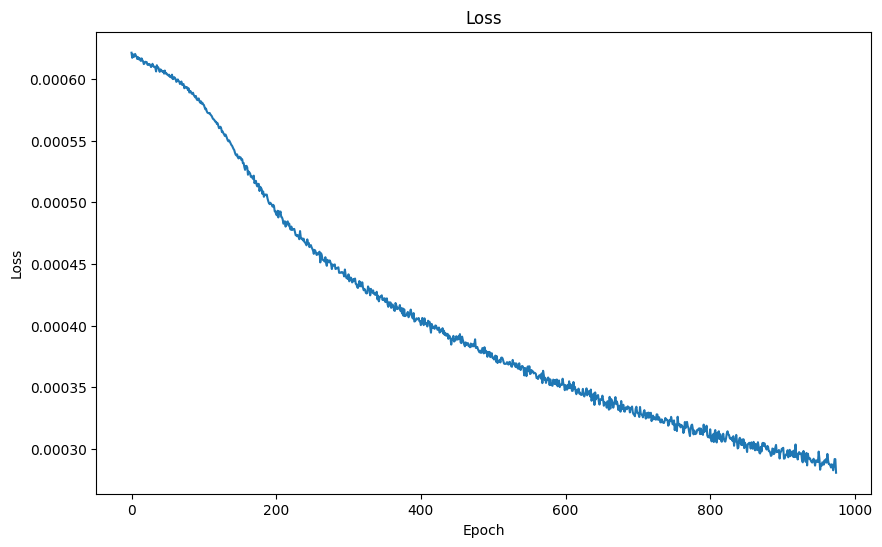

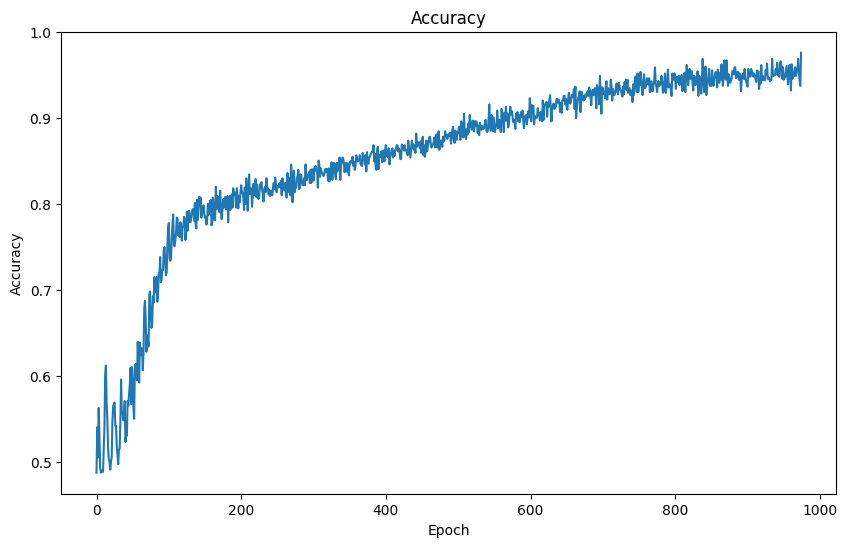

In [44]:
# get the loss and accuracy
loss = [i[0].cpu().detach().numpy() for i in history]
acc = [i[1] for i in history]

print("Max accuracy: ", max(acc))
print("Min loss: ", min(loss))

# plot and show the loss and accuracy without saving
plt.figure(figsize=(10, 6))
plt.plot(loss)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(acc)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [45]:
# test the model
test_acc = model.test(data,
                      test_mask
)
print("Test accuracy: ", test_acc)

Number of testing nodes:  tensor(4471)
Test accuracy:  0.9595168866025497


## GAT

In [78]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels=128, lr=0.001, weight_decay=5e-6):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(-1, hidden_channels, heads=8)
        self.conv2 = GATConv(hidden_channels * 8, 2, heads=1)

        # initialize the optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        # initialize the loss function
        self.criterion = torch.nn.CrossEntropyLoss()

        # copy the model to the device
        self.to(device)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def fit(self, data, mask, epochs, stop_acc=None):

        # print("Number of training nodes: ", mask.sum())
        history = []

        progress = tqdm(total=epochs)
        for _ in range(epochs):

            # put the model in training mode
            self.train()
            self.optimizer.zero_grad()

            out = self(data.features, data.edge_index)
            loss = self.criterion(out[mask], data.VAP[mask]) / mask.sum().float()

            # compute the training accuracy
            pred = out.argmax(dim=1)
            correct = pred[mask] == data.VAP[mask]
            train_acc = int(correct.sum()) / int(len(correct))

            # backpropagate the loss
            loss.backward()
            self.optimizer.step()

            # append the loss and accuracy to the history
            history.append([loss, train_acc])

            # update the progress bar
            progress.set_description("Loss: {}, Train Acc: {}".format(loss, train_acc))
            progress.update(1)

            # if the stop_acc is not None and the training accuracy is greater than or equal to the stop_acc, stop training
            if stop_acc is not None and train_acc >= stop_acc:
                print("Training accuracy reached stop_acc, stopping training...")
                break

        return history

    def test(self, data, mask):

        # print("Number of testing nodes: ", mask.sum())
            
        # put the model in eval mode
        self.eval()

        # get the predictions
        out = self(data.features, data.edge_index)

        # compute the test accuracy
        pred = out.argmax(dim=1)
        correct = pred[mask] == data.VAP[mask]
        test_acc = int(correct.sum()) / int(len(correct))

        return test_acc

In [79]:
# create the model
model_GAT = GAT(
    hidden_channels=128,
    lr=0.001,
    weight_decay=5e-6
)
print(model_GAT)

GAT(
  (conv1): GATConv(-1, 128, heads=8)
  (conv2): GATConv(1024, 2, heads=1)
  (criterion): CrossEntropyLoss()
)


In [80]:
# train the model
history_GAT = model_GAT.fit(data,
    train_mask,
    epochs=5000,
    stop_acc=None
)

Loss: 0.00038832303835079074, Train Acc: 0.8146821844225605: 100%|██████████| 5000/5000 [04:09<00:00, 20.05it/s]


Max accuracy:  0.9042076991942704
Min loss:  0.000290736


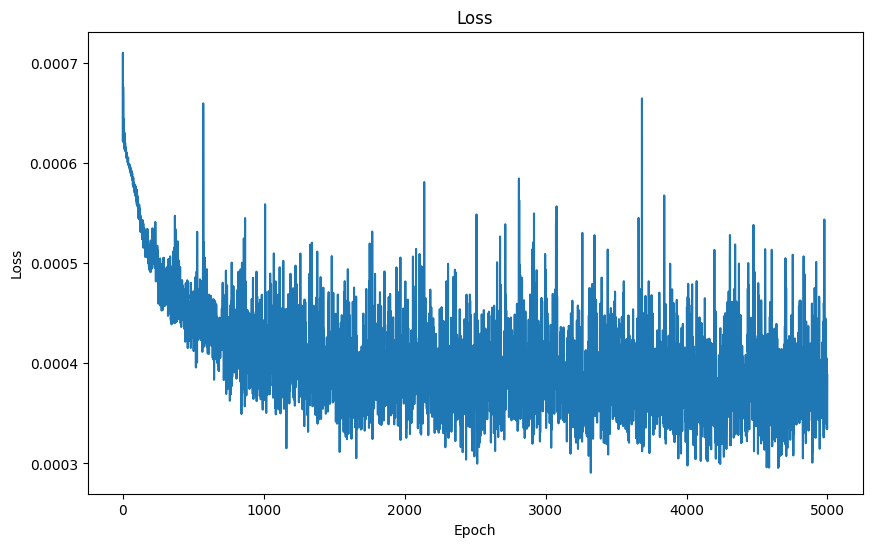

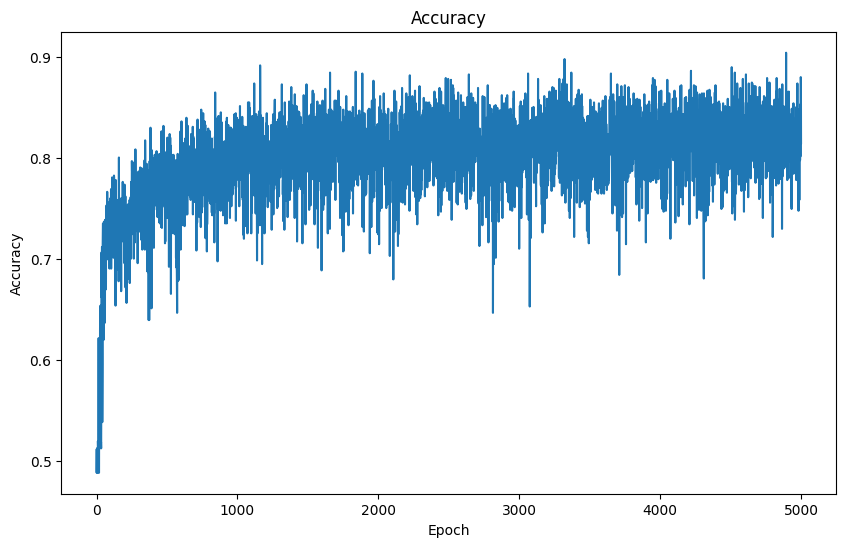

In [82]:
# get the loss and accuracy
loss = [i[0].cpu().detach().numpy() for i in history_GAT]
acc = [i[1] for i in history_GAT]

print("Max accuracy: ", max(acc))
print("Min loss: ", min(loss))

# plot and show the loss and accuracy without saving
plt.figure(figsize=(10, 6))
plt.plot(loss)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(acc)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()